# 3. Featurizing text data with tfidf vectorizer

In [40]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss, confusion_matrix, accuracy_score

## 3.1. Loading  data

### 3.1.1. Loading raw data

In [41]:
df = pd.read_csv("train.csv")
df = df.fillna("")

In [42]:
df.columns

Index(['id', 'qid1', 'qid2', 'question1', 'question2', 'is_duplicate'], dtype='object')

In [43]:
#avoid decoding problem
df["question1"] = df['question1'].apply(lambda x: str(x))
df["question2"] = df['question2'].apply(lambda x: str(x))

In [44]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## 3.1.2 Loading preprocessed data 

In [45]:
#prepro_features_train.csv (Simple Preprocessing Feartures)
#nlp_features_train.csv (NLP Features)
if os.path.isfile('nlp_features_train.csv'):
    df_nlp = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
else:
    print("run previous notebook")

if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df_ppro = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    print("run previous notebook")

In [46]:
df_nlp.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0,0.399992,0.333328,0.399992,0.249997,...,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


In [47]:
df_ppro.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,diff_of_word_count,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,single_word
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,2,10.0,23.0,0.434783,2,0,False
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,-5,4.0,20.0,0.200000,5,3,False
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4,4.0,24.0,0.166667,2,0,False


In [48]:
df1 = df_nlp.drop(['qid1','qid2','question1','question2'],axis=1)
df2 = df_ppro.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

In [49]:
print("Advanced engineered features : ")
df1.head(3)

Advanced engineered features : 


,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_partial_ratio,longest_substr_ratio
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,2.0,13.0,100,93,93,100,0.982759
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,5.0,12.5,86,63,66,75,0.596154
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,4.0,12.0,66,66,54,54,0.166667


In [50]:
print("Basic engineered features : ")
df2.head(3)

Basic engineered features : 


,id,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,diff_of_word_count,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,single_word
0,0,1,1,66,57,14,12,2,10.0,23.0,0.434783,2,0,False
1,1,4,1,51,88,8,13,-5,4.0,20.0,0.200000,5,3,False
2,2,1,1,73,59,14,10,4,4.0,24.0,0.166667,2,0,False


In [51]:
#merging both basic & advanced engineered features in a one df.
df_features = df1.merge(df2, how='left', on='id')

In [52]:
df_features.head(3)

,id,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,ctc_min,ctc_max,last_word_eq,first_word_eq,...,q2len,q1_n_words,q2_n_words,diff_of_word_count,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2,single_word
0,0,0,0.999980,0.833319,0.999983,0.999983,0.916659,0.785709,0.0,1.0,...,57,14,12,2,10.0,23.0,0.434783,2,0,False
1,1,0,0.799984,0.399996,0.749981,0.599988,0.699993,0.466664,0.0,1.0,...,88,8,13,-5,4.0,20.0,0.200000,5,3,False
2,2,0,0.399992,0.333328,0.399992,0.249997,0.399996,0.285712,0.0,1.0,...,59,14,10,4,4.0,24.0,0.166667,2,0,False


In [53]:
df_features.shape

(404290, 30)

In [54]:
df_features_main = df_features

In [55]:
df_features["question1"] = df["question1"]
df_features["question2"] = df["question2"]

In [56]:
df_features.shape

(404290, 32)

In [57]:
#saving "is_duplicate" column separately.
result_class = df_features["is_duplicate"]

#dropping columns 'id' & 'is_duplicate'
df_features.drop(['id', 'is_duplicate'], axis=1, inplace=True)

In [58]:
df_features.shape

(404290, 30)

In [59]:
result_class.shape

(404290,)

## 3.2. Splitting data into train & test

In [60]:
#splitting the dataset into train and test set
#train: 70%
#test : 30%
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(df_features, result_class, random_state=42, test_size=0.3)

In [61]:
print("shape of X train set :", X_train.shape)
print("shape of X test set :", X_test.shape)
print("shape of Y train set :", Y_train.shape)
print("shape of Y test set :", Y_test.shape)

shape of X train set : (283003, 30)
shape of X test set : (121287, 30)
shape of Y train set : (283003,)
shape of Y test set : (121287,)


## 3.3. Featurizing the data using tfidf vectorizer

In [62]:
#collecting all the question available in train set for creating tfidf dictionary
questions_in_train = list(X_train['question1'] + X_train['question2'])

#initializing tfidf vectorizer
tfidf = TfidfVectorizer(ngram_range=(1,3), min_df=10)
tfidf.fit(questions_in_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=10,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [63]:
#create a tfidf vector for questions in train and test

train_q1 = tfidf.transform(X_train["question1"])
train_q2 = tfidf.transform(X_train["question2"])

testq1 = tfidf.transform(X_test["question1"])
testq2 = tfidf.transform(X_test["question2"])

In [64]:
train_q1.shape

(283003, 121863)

In [65]:
testq1.shape

(121287, 121863)

In [66]:
# stacking the sparse matrices
from scipy.sparse import hstack
train_stacked_q12 = hstack((train_q1, train_q2))
test_stacked_q12 = hstack((testq1, testq2))

In [67]:
train_stacked_q12.shape

(283003, 243726)

In [68]:
test_stacked_q12.shape

(121287, 243726)

In [69]:
for features in X_train.columns.values:
    print(features)

cwc_min
cwc_max
csc_min
csc_max
ctc_min
ctc_max
last_word_eq
first_word_eq
abs_len_diff
mean_len
token_set_ratio
token_sort_ratio
fuzz_ratio
fuzz_partial_ratio
longest_substr_ratio
freq_qid1
freq_qid2
q1len
q2len
q1_n_words
q2_n_words
diff_of_word_count
word_Common
word_Total
word_share
freq_q1+q2
freq_q1-q2
single_word
question1
question2


In [70]:
X_train.drop(['question1', 'question2'], axis=1, inplace=True)
X_test.drop(['question1', 'question2'], axis=1, inplace=True)

In [71]:
# stacking the engineered features dataframe with tfidf sparse matrix for both train & test set
X_train = hstack((X_train.astype(float), train_stacked_q12))
X_test = hstack((X_test.astype(float), test_stacked_q12))

In [72]:
#converting to compressed row format.
X_train = X_train.tocsr()
X_test = X_test.tocsr()

In [73]:
X_train.shape

(283003, 243754)

In [74]:
X_test.shape

(121287, 243754)

## 3.4. Machine Learning Models

In [75]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(Y_test, Y_predict):
    C = confusion_matrix(Y_test, Y_predict)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

In [76]:
result = []

### 3.4.1 Logistic Regression

#### 3.4.1.1 Hyperparameter tuning

for alpha values = 1e-07, Log-loss is 0.49983599390636096
for alpha values = 1e-06, Log-loss is 0.44237133432926745
for alpha values = 1e-05, Log-loss is 0.4483148631553401
for alpha values = 0.0001, Log-loss is 0.47459630208004294
for alpha values = 0.001, Log-loss is 0.4468341699148486
for alpha values = 0.01, Log-loss is 0.4507450185949213
for alpha values = 0.1, Log-loss is 0.46203320207810905
for alpha values = 1, Log-loss is 0.4923247660962666
for alpha values = 10, Log-loss is 0.545868591874968
for alpha values = 100, Log-loss is 0.5879067592698202


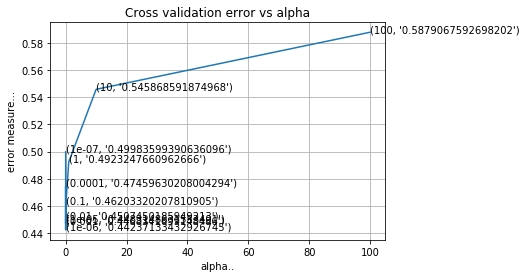

In [77]:
alpha = [10**x for x in range(-7,3)] #hyperparameter for SGDClassifier
cv_log_error = []

for i in alpha:
    clf = SGDClassifier(loss='log', alpha=i, n_jobs=-1)
    clf.fit(X_train, Y_train)
    
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(X_train, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_test)
    
    cv_log_error.append(log_loss(Y_test, sig_clf_probs, eps=1e-15, labels=clf.classes_))
    print("for alpha values = {}, Log-loss is {}".format(i, log_loss(Y_test, sig_clf_probs, eps=1e-15, labels=clf.classes_)))

#plotting the error vs alpha.
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error)
for i, txt in enumerate(cv_log_error):
    ax.annotate((alpha[i], str(txt)),(alpha[i], cv_log_error[i]))
    
plt.title("Cross validation error vs alpha")
plt.xlabel("alpha..")
plt.ylabel("error measure...")
plt.grid()
plt.show()

#### 3.4.1.2 Logistic Regression model using tuned parameters

for optimal alpha values = 1e-06, Train log-loss is 0.4460278866870911
for optimal alpha values = 1e-06, Test log-loss is 0.44645368306547223
Total number of data points : 121287


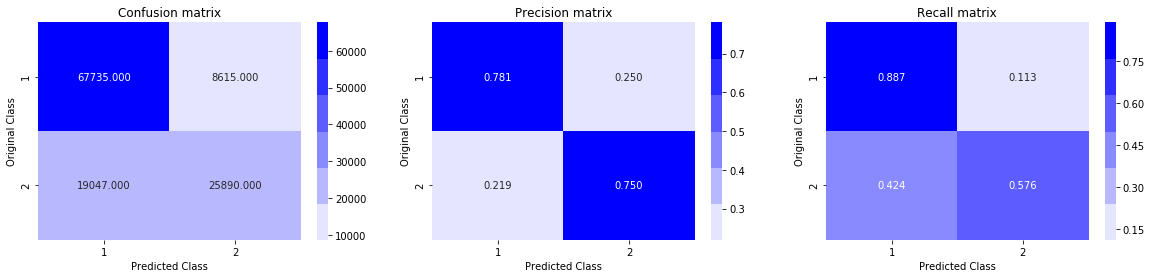

In [79]:
best_alpha = alpha[np.argmin(cv_log_error)]
clf = SGDClassifier(alpha=best_alpha, loss='log', n_jobs=-1)
clf.fit(X_train, Y_train)

sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(X_train, Y_train)

Y_predict = sig_clf.predict_proba(X_train)
print("for optimal alpha values = {}, Train log-loss is {}".format(best_alpha, log_loss(Y_train, Y_predict, eps=1e-15, labels=clf.classes_)))

Y_predict = sig_clf.predict_proba(X_test)
print("for optimal alpha values = {}, Test log-loss is {}".format(best_alpha, log_loss(Y_test, Y_predict, eps=1e-15, labels=clf.classes_)))

log_loss_LR = log_loss(Y_test,Y_predict)

result.append(('Logistic Regression', log_loss(Y_test, Y_predict, eps=1e-15, labels=clf.classes_)))

Y_predicted =np.argmax(Y_predict,axis=1)
print("Total number of data points :", len(Y_predicted))
plot_confusion_matrix(Y_test, Y_predicted)


### 3.4.2 Linear SVM

#### 3.4.2.1 Hyperparameter tuning

for alpha values = 1e-08, Log-loss is 0.659229402694801
for alpha values = 1e-07, Log-loss is 0.5670753266881643
for alpha values = 1e-06, Log-loss is 0.4444574257920397
for alpha values = 1e-05, Log-loss is 0.4432265509699517
for alpha values = 0.0001, Log-loss is 0.4595509186511602
for alpha values = 0.001, Log-loss is 0.46030082624388613
for alpha values = 0.01, Log-loss is 0.45599274341048746
for alpha values = 0.1, Log-loss is 0.4630638519412742
for alpha values = 1, Log-loss is 0.4850111167430792
for alpha values = 10, Log-loss is 0.5408923845578019
for alpha values = 100, Log-loss is 0.5853142882770137


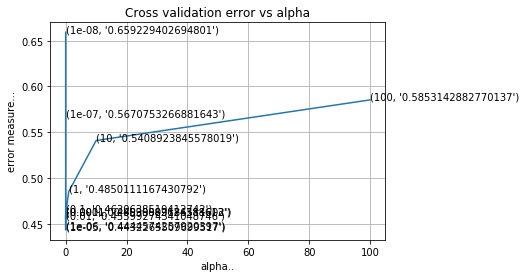

In [80]:
alpha = [10**x for x in range(-8,3)] #hyperparameter for SGDClassifier
cv_log_error = []

for i in alpha:
    clf = SGDClassifier(loss='hinge', alpha=i, n_jobs=-1)
    clf.fit(X_train, Y_train)
    
    sig_clf = CalibratedClassifierCV(clf)
    sig_clf.fit(X_train, Y_train)
    sig_clf_probs = sig_clf.predict_proba(X_test)
    
    cv_log_error.append(log_loss(Y_test, sig_clf_probs, eps=1e-15, labels=clf.classes_))
    print("for alpha values = {}, Log-loss is {}".format(i, log_loss(Y_test, sig_clf_probs, eps=1e-15, labels=clf.classes_)))

#plotting the error vs alpha.
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error)
for i, txt in enumerate(cv_log_error):
    ax.annotate((alpha[i], str(txt)),(alpha[i], cv_log_error[i]))
    
plt.title("Cross validation error vs alpha")
plt.xlabel("alpha..")
plt.ylabel("error measure...")
plt.grid()
plt.show()

#### 3.4.2.2 Linear SVM model using tuned parameters

for optimal alpha values = 1e-05, Train log-loss is 0.4432615357644263
for optimal alpha values = 1e-05, Test log-loss is 0.4448263277723572
Total number of data points : 121287


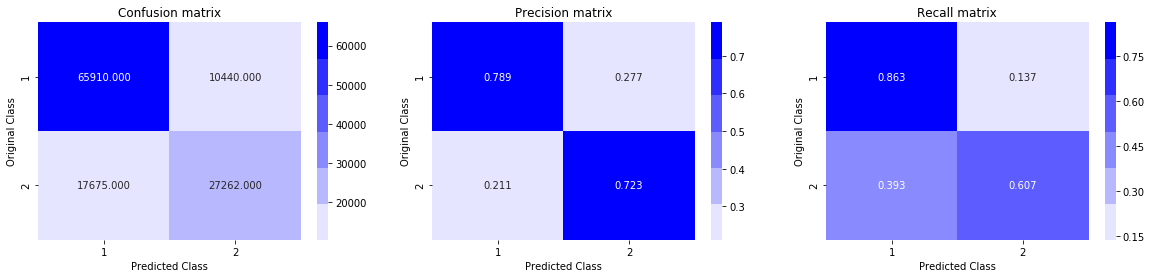

In [81]:
best_alpha = alpha[np.argmin(cv_log_error)]
clf = SGDClassifier(alpha=best_alpha, loss='log', n_jobs=-1)
clf.fit(X_train, Y_train)

sig_clf = CalibratedClassifierCV(clf)
sig_clf.fit(X_train, Y_train)

Y_predict = sig_clf.predict_proba(X_train)
print("for optimal alpha values = {}, Train log-loss is {}".format(best_alpha, log_loss(Y_train, Y_predict, eps=1e-15, labels=clf.classes_)))

Y_predict = sig_clf.predict_proba(X_test)
print("for optimal alpha values = {}, Test log-loss is {}".format(best_alpha, log_loss(Y_test, Y_predict, eps=1e-15, labels=clf.classes_)))

log_loss_SVM = log_loss(Y_test,Y_predict)

result.append(('SVM', log_loss(Y_test, Y_predict, eps=1e-15, labels=clf.classes_)))

Y_predicted =np.argmax(Y_predict,axis=1)
print("Total number of data points :", len(Y_predicted))
plot_confusion_matrix(Y_test, Y_predicted)


## Conclusion

In [83]:
from prettytable import PrettyTable
conclusion_table = PrettyTable()
conclusion_table.field_names = ["Model", "Log-loss"]
conclusion_table.add_row(["Logistic Regression", np.round(log_loss_LR,4)])
conclusion_table.add_row(["Linear SVM", np.round(log_loss_SVM,4)])
    
print(conclusion_table)

+---------------------+----------+
|        Model        | Log-loss |
+---------------------+----------+
| Logistic Regression |  0.4465  |
|      Linear SVM     |  0.4448  |
+---------------------+----------+


<b> Conclusion: </b>
1. TFIDF W2V gives slightly bettter results than simple TFIDF featurization.